# Extreme Value Analysis Advanced Tutorial
This tutorial covers more advanced analysis techniques available in the EVA tool. For a basic introduction to the EVA tool see "Extreme Value Analysis Basic Tutorial". In this tutorial we are going to use the peaks-over-threshold (POT) extreme value extraction method with the distribution of extreme values being modelled using the [Generalized Pareto Distribution (GPD)](https://en.wikipedia.org/wiki/Generalized_Pareto_distribution), parameters of which are going to be inferred using the Markov chain Monte Carlo (MCMC) method. This example uses the same dataset used in the basic tutorial.

## Load data
First, we need to import requried modules and load data. Pre-processed data is available [here](https://www.dropbox.com/s/xgqp2v2f1foyrvb/battery_residuals.csv?dl=0). Let's load the data and plot Hurricane Sandy, which hit New York on October 29 2012, to get a feeling of what the data looks like.

**IMPORTANT NOTE :** input data for the EVA class must be a [pandas](https://pandas.pydata.org/) dataframe with index being date-time and column, in which the data to be analyzed is located, having data as real numbers (int of float).

In [1]:
import matplotlib.pyplot as plt
from coastlib.api import EVA
import pandas as pd
import numpy as np
import scipy.stats


# Ignore warnings since this is a tutorial. Warnings are from scipy.stats.* trying to fit MLE using invalid parameters
# (e.g. scale < 0) and its internal optimizer throwing out warnings for receiving nan's
# (optimizer is general and is not related to MLE)
import warnings
warnings.filterwarnings('ignore')

# Don't forget to tell pandas that first column is index and to parse i as datetime
data = pd.read_csv(
    r'https://dl.dropboxusercontent.com/s/xgqp2v2f1foyrvb/battery_residuals.csv?dl=0',
    index_col=0, parse_dates=True
)

# Plot Hurricane Sandy data
mask = (data.index >= pd.Timestamp(year=2012, month=10, day=22)) & (data.index <= pd.Timestamp(year=2012, month=11, day=5))
sandy = data[mask]
fig = sandy.plot()

## Perform Extreme Value Analysis
### Initialize the EVA object
See "Extreme Value Analysis Basic Tutorial" for discussion of the parameters passed during the EVA object initialization.

In [2]:
analysis = EVA(dataframe=data, column='Residuals (ft)', block_size=365.2425, gap_length=24)

### Extract extreme values
In this example we are using the peaks-over-threshold (POT) extreme values extraction method. This method is advantegous over the block maxima (BM) method, especially for smaller datasets, because it allows extraction of more extreme events than in the BM method and is not limited to highest values within a each year (or block of any other size). The problem with using the POT method, however, lies in subjectivity involved in threshold selection - too high value results in too few peaks resulting in low level of confidence of the model, while too low value causes violation of underlying assumptions (e.g. that the POT extremes represent the upper tail of the original distribution).
#### Find optimal threshold value
Various techniques of finding an optimal value of the threshold have been developed. The EVA tool provides two most common graphical methods - mean residual life plot and parameter stability plot. The mean residual life plot shows averages of exceedances over thresholds and is expected to be approximately linear in the area of valid thresholds. The parameter stability plot shows change of GPD parameters for varying thresholds and should be approximately linear in the area of valid threshold. The smallest threhold for which both of these conditions are met should be selected. The trick is finding this sweet spot, since identifying areas where the plots are linear may require some subjective judgement.

(<Figure size 864x576 with 2 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x208d4b890f0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x208d4ba7eb8>))

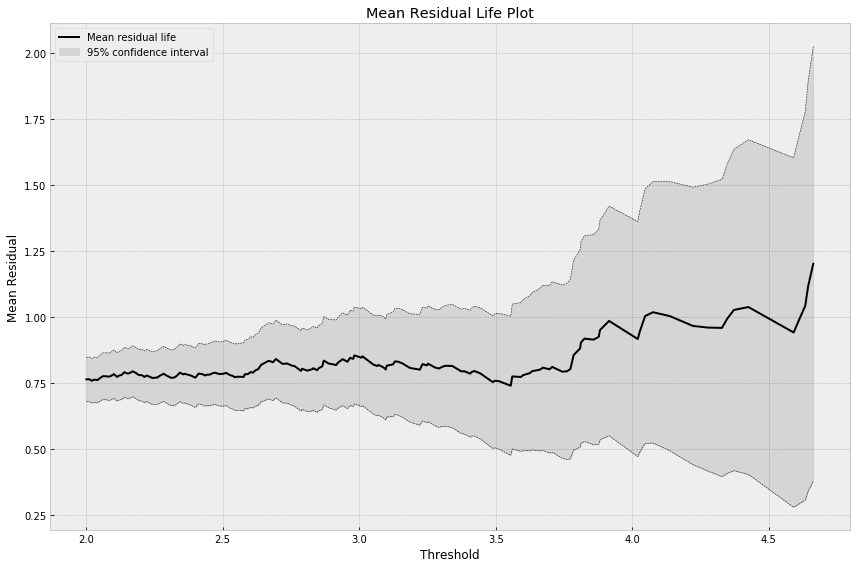

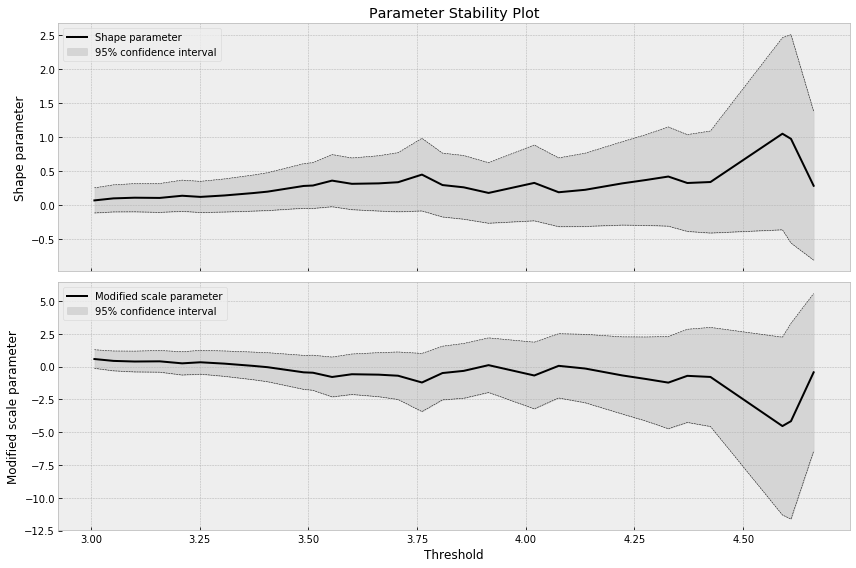

In [3]:
# r represents independent event distance in hours, limit represents minimum number of exceedances for which
# residuals/parameters are estimated, adjust_threshold is a flag used to set actual value of threshold equal
# to the smallest exceedance - this way location parameter is strictly 0
# (GPD is very unstable for non-fixed location parameter)
# Read EVA docstrings for more information
analysis.plot_mean_residual_life(thresholds=np.arange(2, 8, .01), r=24*7, alpha=.95, adjust_threshold=True, limit=10)
analysis.plot_parameter_stability(thresholds=np.arange(3, 8, .05), r=24*7, alpha=.95, adjust_threshold=True, limit=10)

#### Extract extreme values
As seen in the plots above, valid threholds appear to lie above value 3 - mean residual life plot is very hard to interpret since its rarely clearly linear. Let's extract the extreme values and plot them against the timeseries.

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x208d495c2e8>)

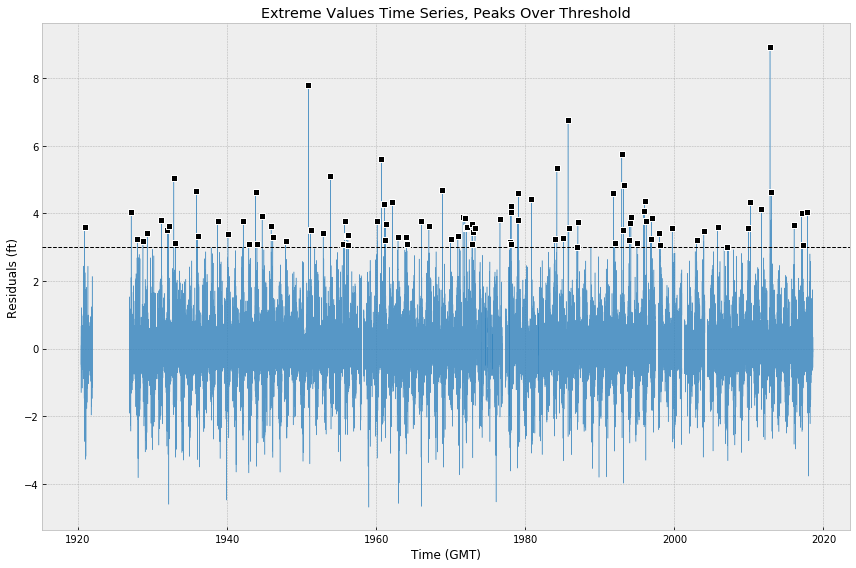

In [4]:
analysis.get_extremes(method='POT', plotting_position='Weibull', r=24*7, threshold=3)
analysis.plot_extremes()

Since the POT method involves declustering extreme events using minimum distance **r**, it is necessary to check if the extracted extreme values are independent (extreme values being iid - independent identically distributed - is one of the main assumptions in the POT-GPD model). This is done by generating an autocorrelation plot and by checking the runs test statistic. Based on the results of these tests it can be seen that the values are sufficiently independent to proceed to the next analysis steps.

Ho : data is random
Ha : data is not random

Test statistic : N = 1.22
Significanse level : alpha = 0.05
Critical value : Nalpha = 1.96
Reject Ho if |N| > Nalpha


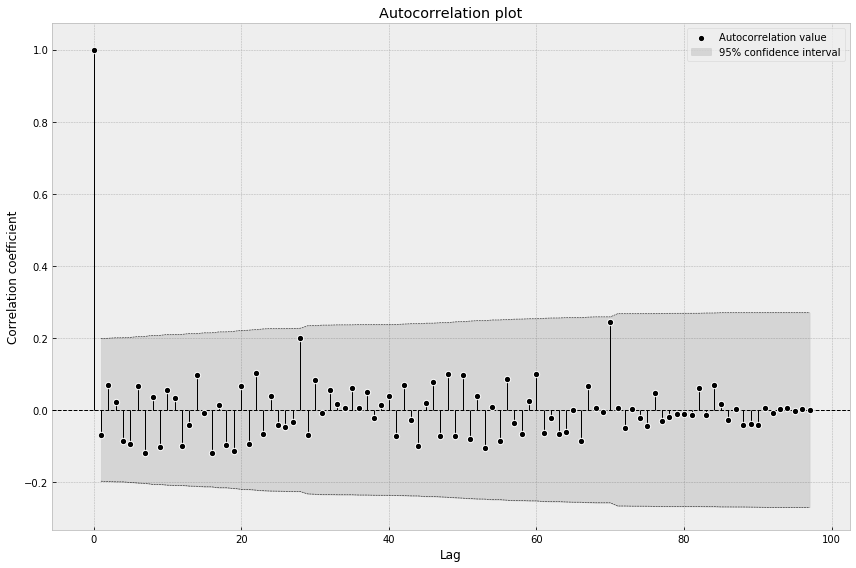

In [5]:
fig, ax = analysis.test_extremes(method='autocorrelation')
print(analysis.test_extremes(method='runs test'))

### Fit the distribution
For the POT extreme value extraction method it is common practice to use the Generalied Pareto Distribution ([read more here](https://en.wikipedia.org/wiki/Generalized_Pareto_distribution)). In this example we are going to infer the distribution parameters using the Markov chain Monte Carlo method ([read more here](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo)). The main advantage of the MCMC method over the MLE method is that instead of yielding a point estimate, it returns an entire posterior distribution for each parameter - this way confidence intervals are more "natural" and easier to obtain. The EVA tool uses [Affine Invariant MCMC Ensemble Sampler](http://dfm.io/emcee/current/) developed by Dan Foreman-Mackey. It is still possible to use the MLE method as discussed in the basic tutorial.

The MCMC method requires **log_prior** and **log_likelihood** functions, which are available by default for 3-parameter GEV and 3- and 2-parameter GPD (location fixed at 0 for 2-parameter GPD, this is the default case) distributions. For other distributions these functions should be defined by the user. An example of custom functions is given further in this tutorial. Let's run the MCMC method and generate a trace plot, which shows all samples for each walker - this way we can see where the sampler "burns in" - i.e. find location of the cutoff after which the useful samples are generated (i.e. the sampler converges to solution).

(<Figure size 864x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000208D4B7F9B0>,
       dtype=object))

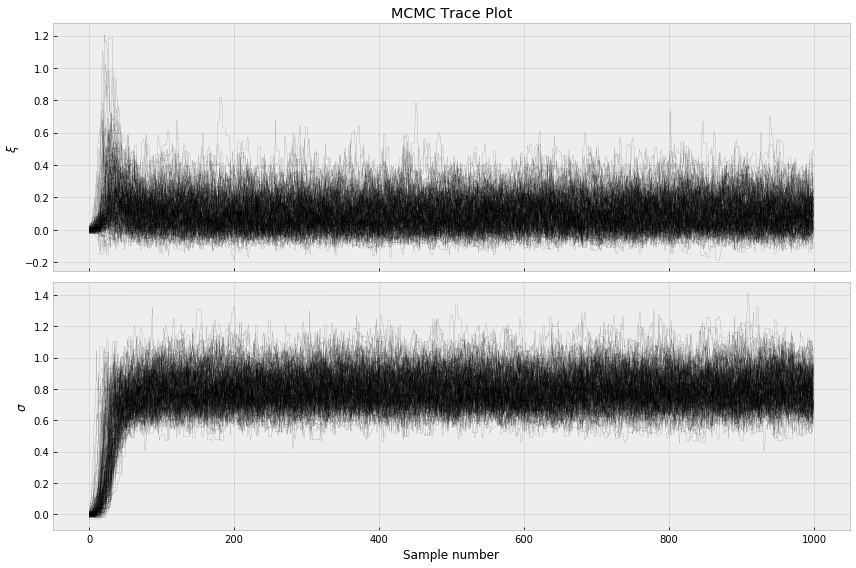

In [6]:
# nsamples corresponds to number of samples each walker draws from the posterior distribution
# nwalkers corresponds to number of walkers exploring the parameter space
# starting bubble defines standard deviation of starting positions of the walkers -
# this way walkers start at different points
analysis.fit(distribution_name='genpareto', fit_method='MCMC', nsamples=1000, nwalkers=200, starting_bubble=.01)
analysis.plot_trace(burn_in=0, labels=[r'$\xi$', r'$\sigma$'])

It can be seen that walkers burn in fairly quickly - after about 50 samples. We will select a burn-in value of 200, which results in 800 samples per walker or 160,000 samples in total. Let's produce an updated trace plot and generate a corner plot to see posterior distributions of the GPD parameters.

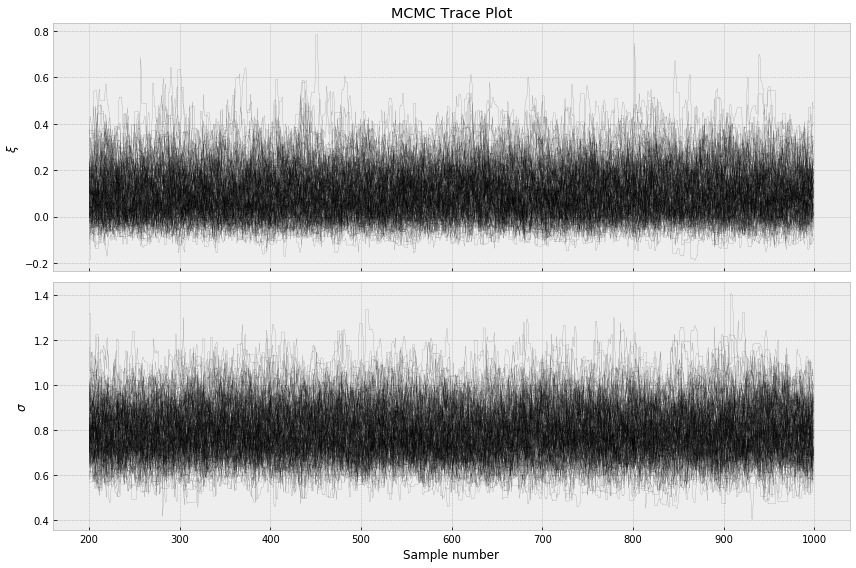

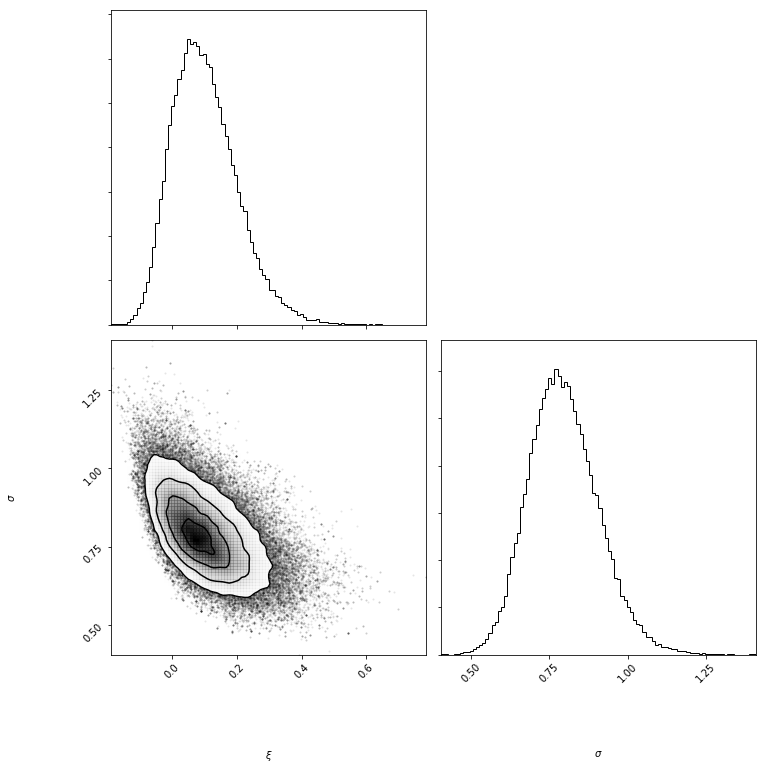

In [7]:
fig, ax = analysis.plot_trace(burn_in=200, labels=[r'$\xi$', r'$\sigma$'])
fig, ax = analysis.plot_corner(burn_in=200, labels=[r'$\xi$', r'$\sigma$'], smooth=1)

It can be seen on the corner plot above that the shape parameter posterior distribution includes 0 as one of its values. This means that, given observed extreme values, it cannot be ruled out with high confidence that the distribution is not degenerate in its shape parameter $\xi=0$. In the degenerate case of $\xi=0$ the Generalized Pareto Distribution is fully equivalent to [exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution), which has only one parameter - scale $\sigma$.

### Generate summary plot and goodness-of-fit statistics
Let's generate some statistical plots to see how well the GPD models the observed extreme events. The Akaike Information Criteria (AIC) is the prime statistic used to compare equivalent (e.g. GPD and exponential distribution) models.

AIC = 166.77
                                   Extreme Value Analysis Summary
Analyzed parameter               Residuals (ft)      Series length                     35854.75 days
Gap length                          24.00 hours      Adjusted series length            33097.04 days
Block size                          365.24 days      Number of blocks                          90.62
Number of extreme events                     98      Extraction method          Peaks Over Threshold
Extreme event rate            1.08 events/block      Plotting position                       Weibull
Threshold                                  3.01      Extreme values type                        high
Distribution                          genpareto      Fit method             Markov chain Monte Carlo
MCMC fit parameters (approximate)[0.07  0.    0.772]


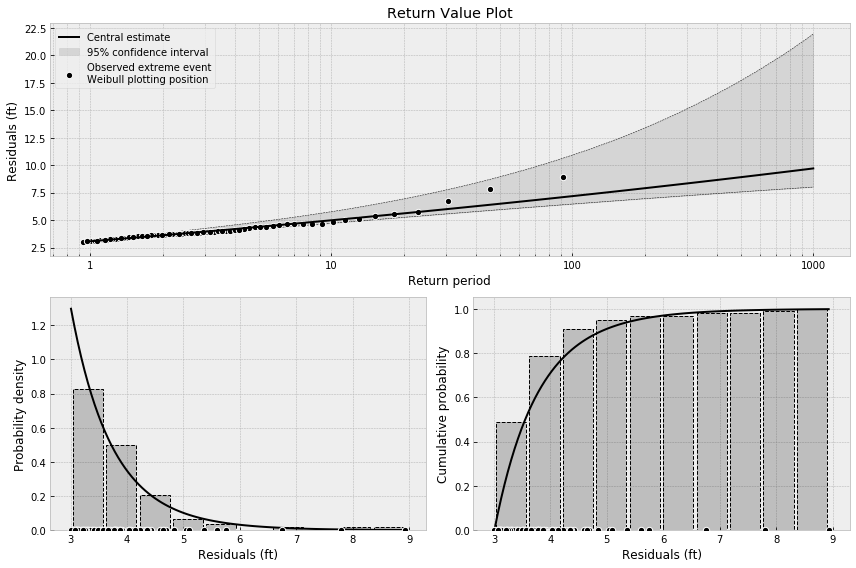

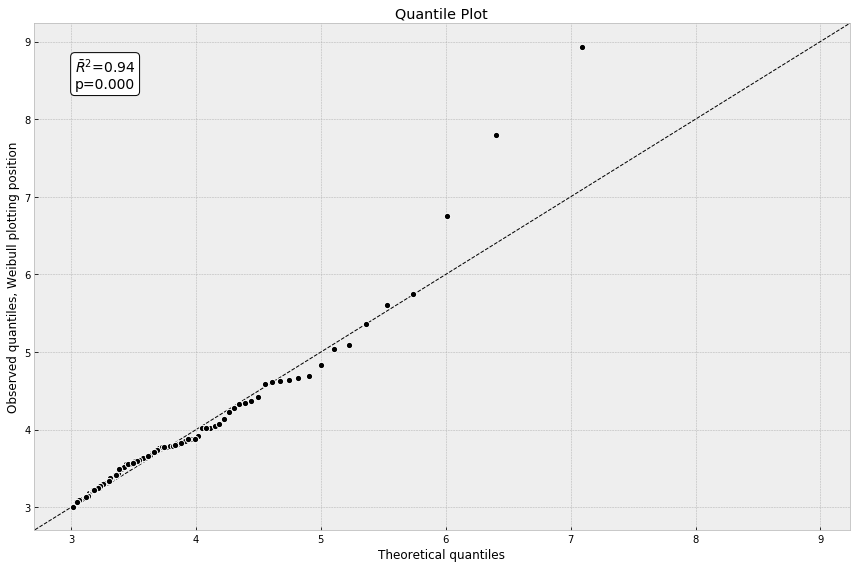

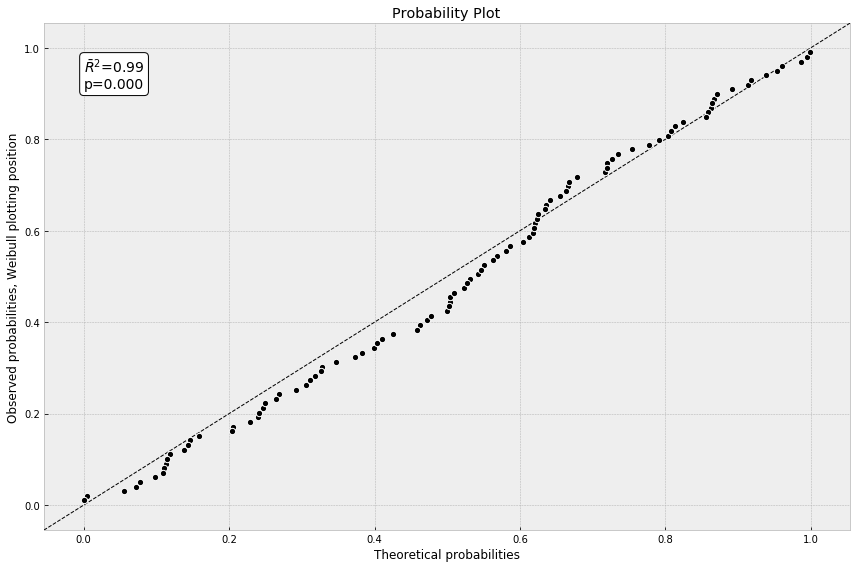

In [8]:
# Since the MCMC method yields distributions of parameters, a gaussian kernel is used to estimate central estimates
# kernel steps parameter defines the accuracy of these estimates 
analysis.generate_results(alpha=.95, ci_kwargs=dict(burn_in=200), rv_kwargs=dict(burn_in=200, kernel_steps=200))
analysis.plot_summary(bins=10, plotting_position='Weibull', rv_kwargs=dict(burn_in=200, kernel_steps=200))
analysis.plot_qq(quantiles=True, plotting_position='Weibull', k=2, rv_kwargs=dict(burn_in=200, kernel_steps=200))
analysis.plot_qq(quantiles=False, plotting_position='Weibull', k=2, rv_kwargs=dict(burn_in=200, kernel_steps=200))
print(f'AIC = {analysis.goodness_of_fit(method="AIC", order=2, k=2, burn_in=200, kernel_steps=200):.2f}')
print(analysis)

### Test for degeneracy
Let's see if the model can be approximated by exponential distribution. For the exponential distribution we need to define custom **log_prior** and **log_likelihood** functions. The log_prior function returns natural logarithm of the probability density of given parameter values (e.g. the parameters can be normally distributed around a certain value - in this case log_prior would return sum of logpdf for every parameter). Since we have no apriori information about the scale parameter distribution, we will use a non-informative uniform distribution - i.e. it is equally likely to observe any value of the parameter.

The log_likelihood function should return sum of natural logarithms of probability density of every observed extreme value - aka sum of loglikelihoods. Both function return negative infinity for invalid scale parameters $\sigma\leq0$ - it is negative since the MCMC sampler looks for parameters maximizing the log-probability function (sum of log_prior and log_likelihood).

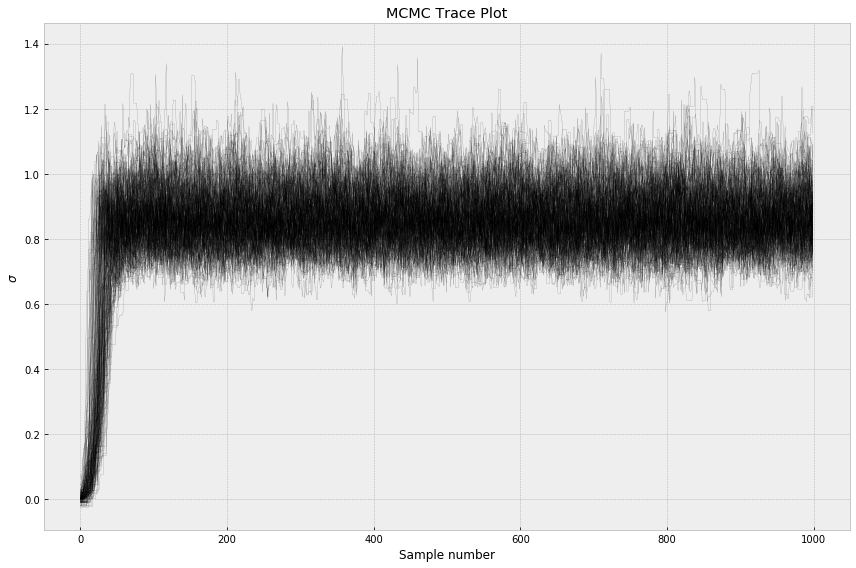

In [9]:
# Define custom log-prior function
# Uniform distribution (all values equally likely) - this is appropriate since we have no prior information
# about the scale parameter value
def log_prior(theta):
    scale = theta[0]
    if scale <= 0:
        return -np.inf
    return 0

# Define custom log-likelihood function
# Fix shape and location parameters at 0 (this way GPD is equivalent to exponential distribution)
def log_likelihood(theta):
    scale = theta[0]
    if scale <= 0:
        return -np.inf
    return np.sum(
        scipy.stats.genpareto.logpdf(
            analysis.extremes[analysis.column].values-analysis.threshold, c=0, loc=0, scale=scale
        )
    )

analysis.fit(
    distribution_name='genpareto', log_prior=log_prior, log_likelihood=log_likelihood,
    fit_method='MCMC', nsamples=1000, nwalkers=200, starting_bubble=.01,
    starting_position=np.array([[0] for _ in range(200)]), fixed_parameters=[(0, 0), (1, 0)]
)
fig, ax = analysis.plot_trace(burn_in=0, labels=['$\sigma$'])

As with the previous scenario (GPD), it can be seen that the walkers burn in rather quickly and that 200 would be an adequate choice of the burn-in value. Let's generate some statistical plots to see how well the exponential distribution models the observed extreme events and how it compares to the GPD model. 

AIC = 165.26
                                   Extreme Value Analysis Summary
Analyzed parameter               Residuals (ft)      Series length                     35854.75 days
Gap length                          24.00 hours      Adjusted series length            33097.04 days
Block size                          365.24 days      Number of blocks                          90.62
Number of extreme events                     98      Extraction method          Peaks Over Threshold
Extreme event rate            1.08 events/block      Plotting position                       Weibull
Threshold                                  3.01      Extreme values type                        high
Distribution                          genpareto      Fit method             Markov chain Monte Carlo
MCMC fit parameters (approximate)[0.    0.    0.838]


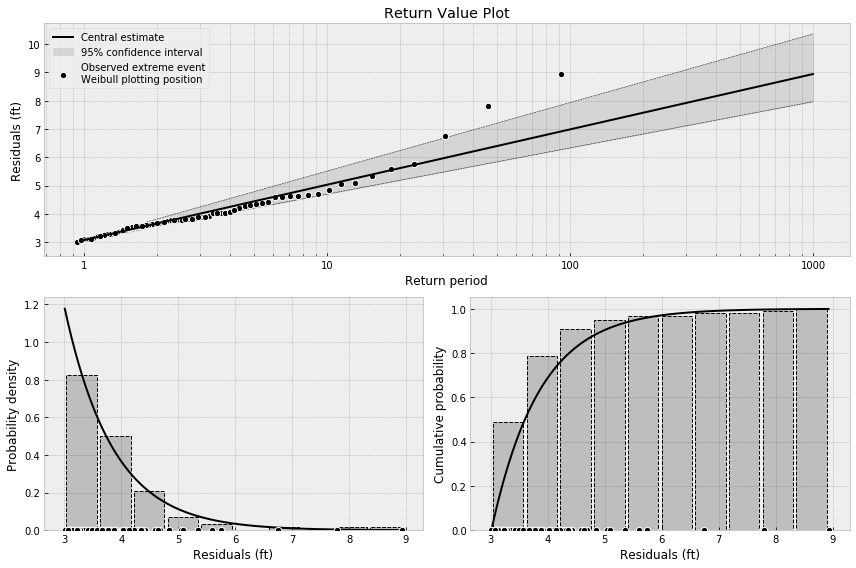

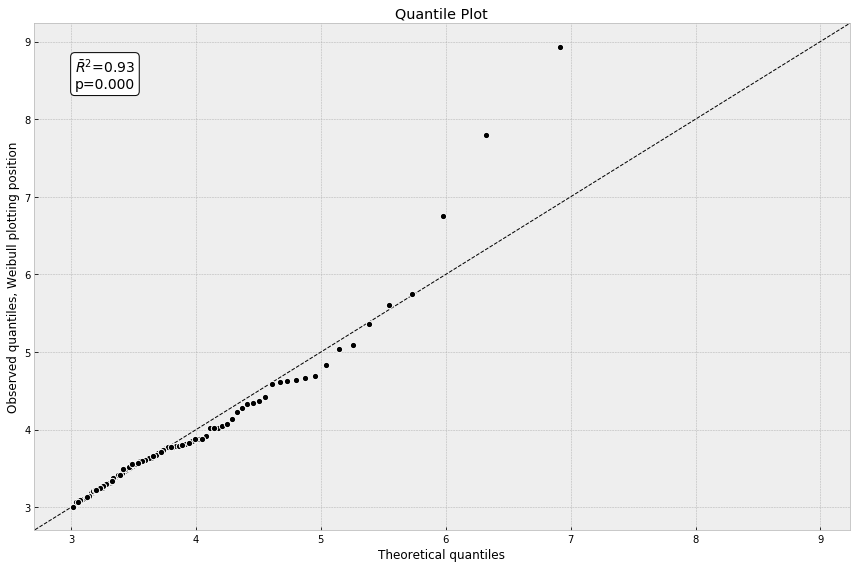

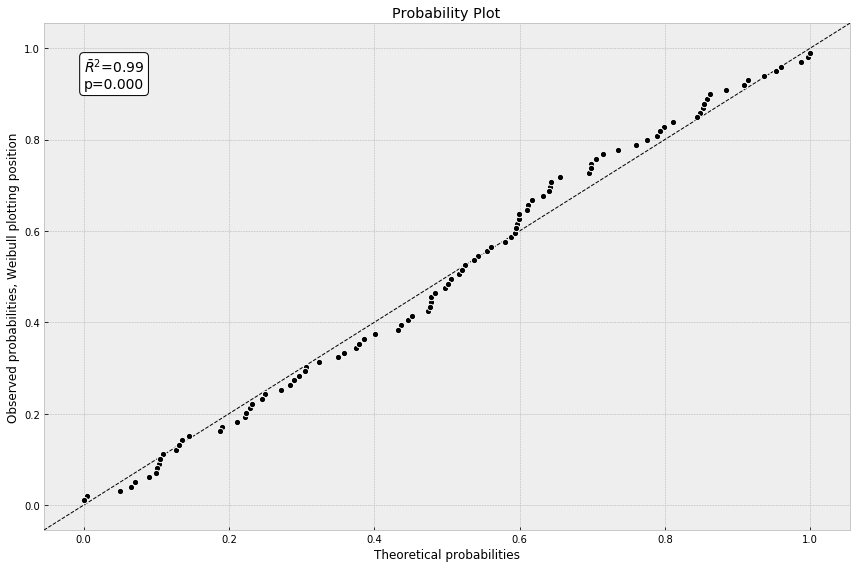

In [10]:
analysis.generate_results(alpha=.95, ci_kwargs=dict(burn_in=200), rv_kwargs=dict(burn_in=200, kernel_steps=200))
analysis.plot_summary(bins=10, plotting_position='Weibull', rv_kwargs=dict(burn_in=200, kernel_steps=200))
analysis.plot_qq(quantiles=True, plotting_position='Weibull', k=1, rv_kwargs=dict(burn_in=200, kernel_steps=200))
analysis.plot_qq(quantiles=False, plotting_position='Weibull', k=1, rv_kwargs=dict(burn_in=200, kernel_steps=200))
print(f'AIC = {analysis.goodness_of_fit(method="AIC", order=2, k=1, burn_in=200, kernel_steps=200):.2f}')
print(analysis)

It can be seen that the exponential distribution fits the observed extreme values reasonably well and has a lower value of AIC as compared to that of the GPD. This leads to a conclusion that exponential distribution is a better model choice for this data. One of the biggest advantages of exponential distribution as compared to the GPD model is that it produces much narrower confidence intervals due to having less parameters (uncertainty).
#### Remarks
Additional methods, such as `to_pickle`, `read_pickle`, `return_value`, `confidence_interval`, and many others, are available for the POT method. Information on how to use these methods can be found in the EVA source dosctrings.

Additional functionality of the EVA tool, such as finding extreme low events (both basic and advanced tutorials cover extreme high value analysis), goodness-of-fit statistics, posterior plots, extreme values independence tests, etc., is covered in the EVA class docstrings.